<a href="https://colab.research.google.com/github/fabiobento/dnn-course-2024-1/blob/main/00_course_folder/cert_prof_time_series/class_03/TS%20-%20W3%20-%2007%20-%20RNN%20(Laborat%C3%B3rio%201).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

adaptado de [Certificado Profissional Desenvolvedor do TensorFlow](https://www.coursera.org/professional-certificates/tensorflow-in-practice) de [Laurence Moroney](https://laurencemoroney.com/)

# Uso de um RNN simples para previsão

Neste laboratório, você começará a usar redes neurais recorrentes (RNNs) para criar um modelo de previsão. Em particular, você vai:

* Criar uma RNN empilhada usando camadas `simpleRNN`.
* usar camadas `Lambda` para remodelar a entrada e dimensionar a saída
* usar a perda Huber durante o treinamento
* Usar janelas de dados em lote para gerar previsões de modelos.

Você treinará esse modelo com o mesmo conjunto de dados sintéticos vistos anteriormente, portanto, as etapas iniciais serão as mesmas. Vamos começar!

## Importações

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2024-04-13 12:42:21.066798: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-13 12:42:21.288503: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-13 12:42:21.288531: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-13 12:42:21.289589: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-13 12:42:21.372560: I tensorflow/core/platform/cpu_feature_g

## Utilitários

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualiza dados de séries temporais

    Args:
      time (vetor de int) - contém as etapas de tempo
      series (vetor de int) - contém as medidas para cada etapa de tempo
      format - estilo de linha ao plotar o gráfico
      start - primeiro passo de tempo a ser plotado
      end - última etapa de tempo a ser plotada
    """

    # Configuração das dimensões da figura do gráfico
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

      for series_num in series:
        # Plotar os dados da série temporal
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plotar os dados da série temporal
      plt.plot(time[start:end], series[start:end], format)

    # Rotular o eixo x
    plt.xlabel("Time")

    # Rotular o eixo y
    plt.ylabel("Value")

    # Sobrepor uma grade no gráfico
    plt.grid(True)

    # Desenhe o gráfico na tela
    plt.show()

def trend(time, slope=0):
    """
    Gera dados sintéticos que seguem uma linha reta com um valor de inclinação.

    Args:
      time (vetor de int) - contém as etapas de tempo
      slope (float) - determina a direção e a inclinação da linha

    Retorna:
      series (vetor de float) - medições que seguem uma linha reta
    """

    # Calcula a série linear dada a inclinação
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Apenas um padrão arbitrário, você pode alterá-lo se desejar

    Args:
      season_time (vetor de float) - contém as medições por etapa de tempo

    Retorna:
      data_pattern (vetor de float) - contém os valores de medição revisados de acordo com o padrão definido.
                                  de acordo com o padrão definido
    """

    # Gerar os valores usando um padrão arbitrário
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repete o mesmo padrão em cada período

    Args:
      time (array of int) - contém as etapas de tempo
      period (int) - número de etapas de tempo antes da repetição do padrão
      amplitude (int) - valor de pico medido em um período
      phase (int) - número de etapas de tempo para deslocar os valores medidos

    Retorna:
      data_pattern (array of float) - dados sazonais dimensionados pela amplitude definida
    """

    # Definir os valores medidos por período
    season_time = ((time + phase) % period) / period

    # Gera os dados sazonais dimensionados pela amplitude definida
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Gera um sinal ruidoso normalmente distribuído

    Args:
      time (vetor de int) - contém as etapas de tempo
      noise_level (float) - fator de escala para o sinal gerado
      seed (int) - semente do gerador de números para repetibilidade

    Retorna:
      noise (vetor de float) - o sinal ruidoso
    """

    # Inicializar o gerador de números aleatórios
    rnd = np.random.RandomState(seed)

    # Gerar um número aleatório para cada etapa de tempo e dimensionar pelo nível de ruído
    noise = rnd.randn(len(time)) * noise_level

    return noise

## Gerar os dados sintéticos

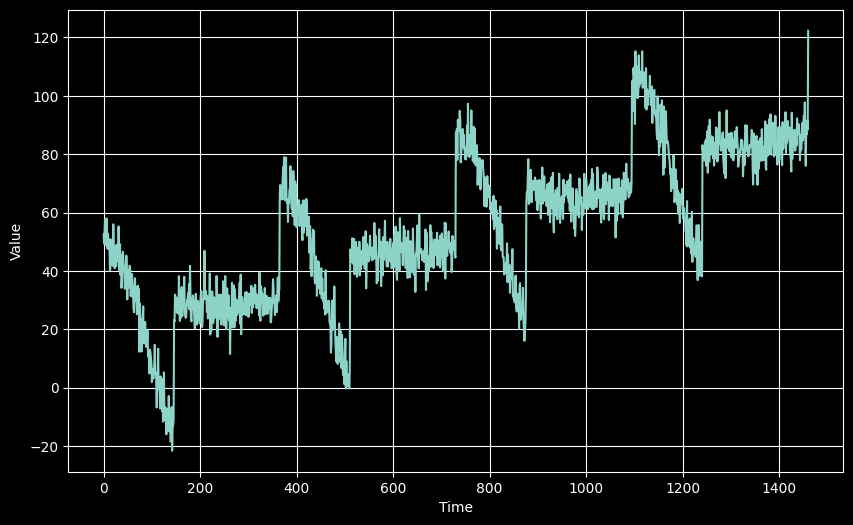

In [3]:
# Hyperparâmetros
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Criar a série
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Adicionar ruído
series += noise(time, noise_level, seed=42)

# Plotar os resultados
plot_series(time, series)

## Dividir o conjunto de dados

In [4]:
# Definir o tempo de divisão
split_time = 1000

# Obter o conjunto de treino
time_train = time[:split_time]
x_train = series[:split_time]

# Obter o conjunto de validação
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

In [5]:
# Hyperparâmetros
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Gera janelas de conjunto de dados

    Args:
      series (vetor de float) - contém os valores da série temporal
      window_size (int) - o número de etapas de tempo a serem incluídas no recurso
      batch_size (int) - o tamanho do lote
      shuffle_buffer(int) - tamanho do buffer a ser usado para o método shuffle

    Retorna:
      dataset (TF Dataset) - Conjunto de dados TF contendo janelas de tempo
    """

    # Gerar um conjunto de dados TF a partir dos valores da série
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Janela de dados, mas só pega aqueles com o tamanho especificado
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Achatar as janelas, colocando seus elementos em um único lote
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Criar tuplas com recursos e rótulos
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Embaralhar as janelas
    dataset = dataset.shuffle(shuffle_buffer)

    # Criar lotes de janelas
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [7]:
# Gerar as janelas do conjunto de dados
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

2024-04-13 12:42:23.393827: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-13 12:42:23.408112: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-13 12:42:23.408588: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [8]:
# Imprimir formato de recursos e rótulos
for window in dataset.take(1):
  print(f'shape of feature: {window[0].shape}')
  print(f'shape of label: {window[1].shape}')

shape of feature: (32, 20)
shape of label: (32,)


## Construir o modelo

Seu modelo é composto principalmente de camadas [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN). Esse tipo de RNN simplesmente encaminha sua saída de volta para a entrada. Você empilhará duas dessas camadas em seu modelo, de modo que a primeira deve ter `return_sequences` definida como `True`.

Conforme mencionado na [documentação](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN#call_arguments), as camadas `SimpleRNN` esperam uma entrada de tensor tridimensional com a forma `[batch, timesteps, feature`]. Com isso, você precisa remodelar sua janela de `(32, 20)` para `(32, 20, 1)`. Isso significa que os 20 pontos de dados na janela serão mapeados para 20 intervalos de tempo do RNN. Você pode fazer essa remodelagem em uma célula separada, mas também pode fazer isso dentro do próprio modelo usando camadas [Lambda](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda). Observe a primeira camada abaixo. Ela define uma função lambda que adiciona uma dimensão no último eixo da entrada. Essa é exatamente a transformação de que você precisa. Para o `input_shape`, você pode especificar `None` se quiser que o modelo seja mais flexível com o número de passos de tempo. Como alternativa, você pode defini-lo como `window_size`, conforme mostrado abaixo, se quiser definir a dimensão `timesteps` com o tamanho esperado das janelas de dados.

Normalmente, você pode ter apenas uma saída de camada `Dense` como mostrado nos laboratórios anteriores. No entanto, você pode ajudar no treinamento aumentando a escala da saída para que ela tenha aproximadamente o mesmo valor dos rótulos. Isso dependerá das [funções de ativação](https://en.wikipedia.org/wiki/Activation_function#Table_of_activation_functions) que você usou no modelo. O `SimpleRNN` usa *tanh* por padrão e tem um intervalo de saída de `[-1,1]`. Você usará outra camada `Lambda()` para dimensionar a saída em 100 antes de ajustar os pesos da camada. Sinta-se à vontade para remover essa camada depois deste laboratório e ver os resultados obtidos.

In [9]:
# Construa o modelo
model_tune = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Exiba os resultados
model_tune.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 20, 1)             0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 20, 40)            1680      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 4961 (19.38 KB)
Trainable params: 4961 (19.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Ajuste a taxa de aprendizagem

Em seguida, você ajustará a taxa de aprendizagem como antes. Você definirá um planejamento de taxa de aprendizagem que altere esse hiperparâmetro dinamicamente. Você usará a [Perda de Huber](https://en.wikipedia.org/wiki/Huber_loss) como sua função de perda para minimizar a sensibilidade a outliers.

In [10]:
# Definir o agendador de taxa de aprendizado
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Inicializar o otimizador
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Definir os parâmetros de treinamento
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Treinar o modelo
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


2024-04-13 12:42:25.122824: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x707e58a988a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-13 12:42:25.122842: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 SUPER, Compute Capability 7.5
2024-04-13 12:42:25.136510: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2024-04-13 12:42:25.192914: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


31/31 [==============================] - 2s 10ms/step - loss: 56.0375 - lr: 1.0000e-08
Epoch 2/100
10/31 [========>.....................] - ETA: 0s - loss: 52.4311

2024-04-13 12:42:25.615873: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8319860715355572090


31/31 [==============================] - 0s 10ms/step - loss: 51.8941 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 10ms/step - loss: 47.5856 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 10ms/step - loss: 43.3675 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 10ms/step - loss: 39.1822 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 10ms/step - loss: 34.9308 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 9ms/step - loss: 30.5518 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 7ms/step - loss: 26.0421 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 8ms/step - loss: 21.6318 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 0s 9ms/step - loss: 17.8027 - lr: 2.8184e-08
Epoch 11/100
31/31 [==============================] - 0s 10ms/step - loss: 15.3944 - lr: 3.1623e-08
Epoch 12/100
31/31 [====

Você pode visualizar os resultados e escolher uma taxa de aprendizado ideal.

(1e-08, 0.001, 0.0, 50.0)

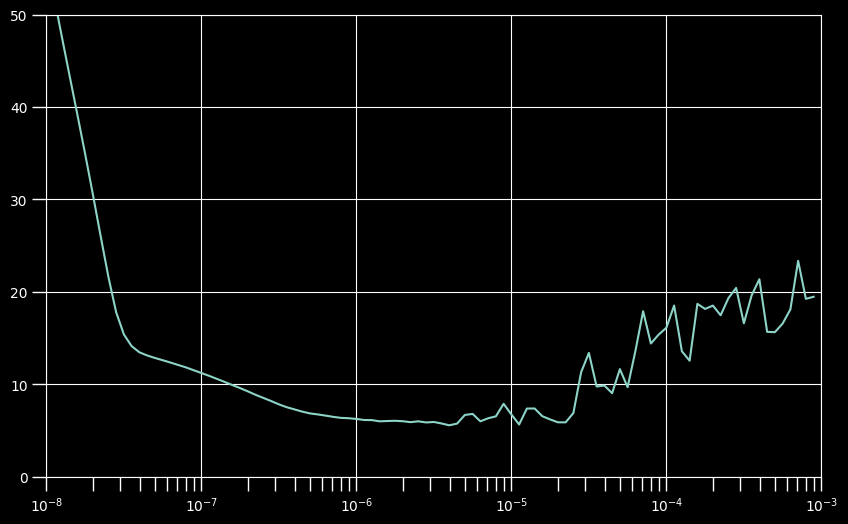

In [11]:
# Definir a matriz de taxa de aprendizado
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Definir o tamanho da figura
plt.figure(figsize=(10, 6))

# Definir a grade
plt.grid(True)

# Plotar a perda em escala logarítmica
plt.semilogx(lrs, history.history["loss"])

# Aumentar o tamanho dos tickmarks
plt.tick_params('both', length=10, width=1, which='both')

# Definir os limites do gráfico
plt.axis([1e-8, 1e-3, 0, 50])

Você pode alterar os limites do gráfico se quiser aumentar o zoom. A célula abaixo escolhe um intervalo mais estreito para que você possa ver mais claramente onde o gráfico se torna instável.

(1e-07, 0.0001, 0.0, 20.0)

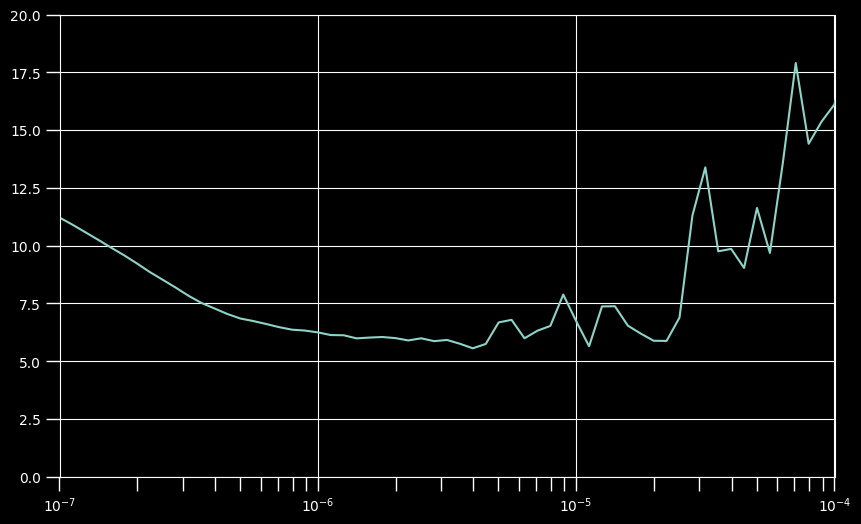

In [12]:
# Definir o tamanho da figura
plt.figure(figsize=(10, 6))

# Definir a grade
plt.grid(True)

# Plotar a perda em escala logarítmica
plt.semilogx(lrs, history.history["loss"])

# Aumentar o tamanho dos tickmarks
plt.tick_params('both', length=10, width=1, which='both')

# Definir os limites do gráfico
plt.axis([1e-7, 1e-4, 0, 20])

## Treinar o modelo

Em seguida, você pode declarar o modelo novamente e treinar com a taxa de aprendizado que escolheu. Por padrão, ela é definida como `1e-6`, mas fique à vontade para alterá-la.

In [18]:
# Construir o modelo
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Definir a taxa de aprendizado
learning_rate = 1e-6

# Definir o otimizador
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Definir os parâmetros de treinamento
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Treinar o modelo
history = model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 1s 9ms/step - loss: 23.1941 - mae: 23.6896
Epoch 2/100
13/31 [===========>..................] - ETA: 0s - loss: 10.8766 - mae: 11.3592

2024-04-13 12:44:42.462536: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8319860715355572090


31/31 [==============================] - 0s 10ms/step - loss: 9.9685 - mae: 10.4537
Epoch 3/100
31/31 [==============================] - 0s 14ms/step - loss: 8.2391 - mae: 8.7241
Epoch 4/100
31/31 [==============================] - 0s 10ms/step - loss: 8.3040 - mae: 8.7905
Epoch 5/100
31/31 [==============================] - 0s 10ms/step - loss: 8.1342 - mae: 8.6207
Epoch 6/100
31/31 [==============================] - 0s 10ms/step - loss: 7.8808 - mae: 8.3685
Epoch 7/100
31/31 [==============================] - 0s 10ms/step - loss: 7.4313 - mae: 7.9144
Epoch 8/100
31/31 [==============================] - 0s 9ms/step - loss: 7.2637 - mae: 7.7445
Epoch 9/100
31/31 [==============================] - 0s 9ms/step - loss: 7.0070 - mae: 7.4909
Epoch 10/100
31/31 [==============================] - 0s 9ms/step - loss: 6.7931 - mae: 7.2717
Epoch 11/100
31/31 [==============================] - 0s 8ms/step - loss: 6.6615 - mae: 7.1421
Epoch 12/100
31/31 [==============================] - 0s 9ms/st

## Previsão do modelo

Agora é hora de gerar as previsões do modelo para o intervalo de tempo do conjunto de validação. O modelo é muito maior do que os que você usou anteriormente e a natureza sequencial dos RNNs (ou seja, as entradas passam por uma série de etapas de tempo em vez de processamento paralelo) pode tornar as previsões um pouco lentas. Você pode observar isso ao usar o código que executou no laboratório anterior. Isso levará cerca de um minuto para ser concluído.

1/1 [==============================] - 0s 11ms/step


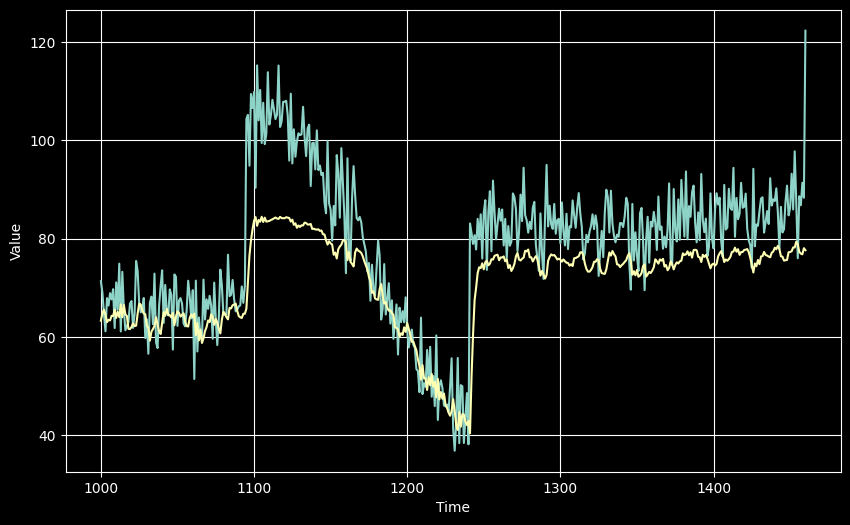

In [14]:
# Initialize a list
forecast = []

# Reduzir a série original
forecast_series = series[split_time - window_size:]

# Use o modelo para prever pontos de dados por tamanho de janela
for time in range(len(forecast_series) - window_size):
  forecast.append(model.predict(forecast_series[time:time + window_size][np.newaxis]))

# Converta em uma matriz numérica e elimine os eixos de dimensão única
results = np.array(forecast).squeeze()

# Plotar os resultados
plot_series(time_valid, (x_valid, results))

Você pode otimizar essa etapa aproveitando a capacidade dos modelos do Tensorflow de processar lotes. Em vez de executar o loop for acima, que processa uma única janela de cada vez, você pode passar um lote inteiro de janelas e deixar que o modelo as processe em paralelo.

A função abaixo faz exatamente isso. Você notará que ela quase espelha a função `windowed_dataset()`, mas não embaralha as janelas. Isso ocorre porque queremos que a saída esteja em sua sequência adequada para que possamos compará-la corretamente com o conjunto de validação.

In [15]:
def model_forecast(model, series, window_size, batch_size):
    """Usa um modelo de entrada para gerar previsões em janelas de dados

    Args:
      model (TF Keras Model) - modelo que aceita janelas de dados
      series (vetor de float) - contém os valores da série temporal
      window_size (int) - o número de etapas de tempo a serem incluídas na janela
      batch_size (int) - o tamanho do lote

    Retorna:
      forecast (matriz numpy) - matriz que contém as previsões
    """

    # Generate a TF dataset from the values in the series
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Janela de dados, mas só pega aqueles com o tamanho especificado
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Achatar as janelas, colocando seus elementos em um único lote
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Criar lotes de janelas
    dataset = dataset.batch(batch_size).prefetch(1)

    # Obter previsões em todo o conjunto de dados
    forecast = model.predict(dataset)

    return forecast

Você pode executar a função abaixo para usar a função. Observe que as previsões são geradas quase instantaneamente.

*Observação: você pode notar que a primeira linha corta a `série` em `split_time - window_size:-1`, o que é um pouco diferente do código for-loop mais lento. Isso ocorre porque queremos que o modelo tenha sua última previsão alinhada com o último ponto do conjunto de validação (ou seja, `t=1460`). Você conseguiu fazer isso com o código for-loop mais lento especificando o `range()` do for-loop. Com a função mais eficiente acima, você não tem esse mecanismo, portanto, em vez disso, basta remover o último ponto ao cortar a `série`. Se você não fizer isso, a função gerará uma previsão em `t=1461` que está fora do intervalo do conjunto de validação.*

15/15 [==============================] - 0s 4ms/step


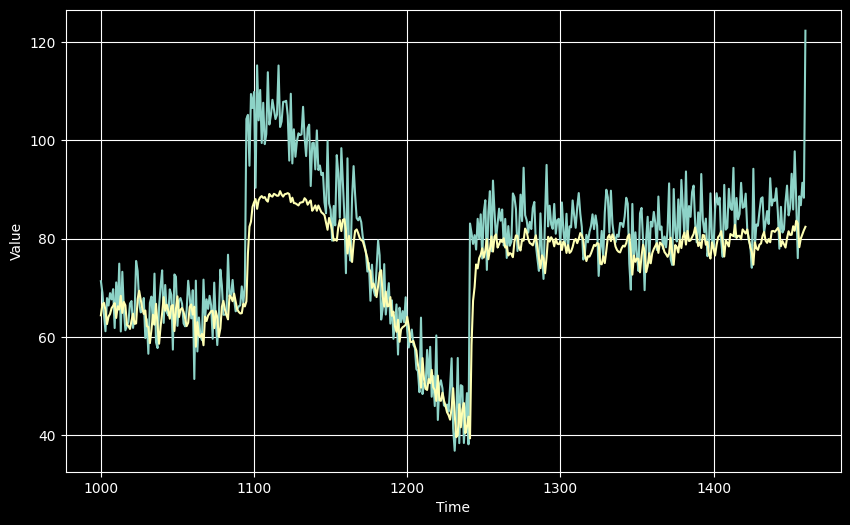

In [19]:
# Reduzir a série original
forecast_series = series[split_time - window_size:-1]

# Use a função auxiliar para gerar previsões
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Soltar eixo unidimensional
results = forecast.squeeze()

# Plotar os resultados
plot_series(time_valid, (x_valid, results))

Em seguida, você pode calcular o MSE e o MAE. Você pode comparar os resultados aqui ao usar outras arquiteturas RNN, o que será feito no próximo laboratório.

In [17]:
# Calcular o MSE e o MAE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

119.85219
8.437426
